In [35]:
# import dependencies

import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

import plotly.express as px
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor

### Download data from AWS RDS to DataFrame

In [3]:
# Database engine to connect with AWS RDS

dialect = 'postgresql'
username = 'postgres'
password = 'bootcamp2021'
host = 'bootcamp-final-cln.ch1wrcuq3max.us-east-2.rds.amazonaws.com'
database = 'crime'
engine = create_engine(f'{dialect}://{username}:{password}@{host}/{database}')

In [4]:
# upload additional tables

property_type_df_file = os.path.join('data_prep', 'property_type_df.csv')
pd.read_csv(property_type_df_file).to_sql(name='property_type_crime', con=engine, if_exists='replace')

violent_type_df_file = os.path.join('data_prep', 'violent_type_df.csv')
pd.read_csv(violent_type_df_file).to_sql(name='violent_type_crime', con=engine, if_exists='replace')

In [5]:
# list all the tables on the AWS RDS

inspector = inspect(engine)
inspector.get_table_names()

['offense_cat_offender_race_2020',
 'offense_cat_offender_sex_2020',
 'offense_cat_type_2020',
 'offense_cat_victim_age_2020',
 'offense_cat_victim_race_2020',
 'offense_cat_victim_sex_2020',
 'state_pop_agencies_2020',
 'gpd_by_state_2020',
 'state_size',
 'property_type_crime',
 'violent_type_crime',
 'offense_cat_loc_2020',
 'offense_cat_state_2020',
 'law_enforcement_state_2020',
 'law_enforcement_state_city_2020',
 'offense_cat_offender_age_2020']

In [6]:
with engine.connect() as conn:
    violent_crime_df = pd.read_sql("SELECT * FROM violent_type_crime", conn)
    property_crime_df = pd.read_sql("SELECT * FROM property_type_crime", conn)

property_crime_df.drop(['index'], axis=1, inplace=True)
property_crime_df.set_index('FIPS', inplace=True)

violent_crime_df.drop('index', axis=1, inplace=True)
violent_crime_df.set_index('FIPS', inplace=True)

print(property_crime_df.shape)
print(violent_crime_df.shape)

(2000, 15)
(2071, 15)


In [7]:
violent_crime_df.head()

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
FIPS,,,,,,,,,,,,,,,
1001.0,384.0,69,31,38,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1003.0,737.0,296,111,185,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
1007.0,69.0,10,9,1,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
1015.0,211.0,56,51,5,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
1033.0,267.0,53,34,19,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6


In [8]:
property_crime_df.head()

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
FIPS,,,,,,,,,,,,,,,
1001.0,55.0,69,31,38,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1003.0,163.0,296,111,185,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
1007.0,3.0,10,9,1,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
1015.0,18.0,56,51,5,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
1033.0,58.0,53,34,19,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6


### Analyse violent crimes

#### normalize columns against population

In [136]:
df = violent_crime_df
df.head()

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
FIPS,,,,,,,,,,,,,,,
1001.0,384.0,69,31,38,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1003.0,737.0,296,111,185,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
1007.0,69.0,10,9,1,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
1015.0,211.0,56,51,5,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
1033.0,267.0,53,34,19,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6


In [137]:
# normalize columns against population

columns_to_normalize = [
    'crimes',
    'total_law_emp',
    'officers',
    'civilians'    
]

for col in columns_to_normalize:
    df[col] = df[col] / df['population']

df.head()

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
FIPS,,,,,,,,,,,,,,,
1001.0,0.006957,0.001250,0.000562,0.000688,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1003.0,0.003541,0.001422,0.000533,0.000889,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
1007.0,0.003063,0.000444,0.000400,0.000044,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
1015.0,0.001833,0.000487,0.000443,0.000043,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
1033.0,0.004900,0.000973,0.000624,0.000349,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6


#### Scale the input dataset

In [142]:
y = df['crimes']
X = df.drop('crimes', axis=1)

# y = np.asarray(y).reshape(-1, 1)

# Create scaler instance
X_scaler = StandardScaler(with_mean=False) # keep positive
y_scaler = StandardScaler(with_mean=False) # keep positive

# Fit the scaler
X_scaler.fit(X)
y_scaler.fit(np.asarray(y).reshape(-1, 1))

# Scale the data
scaled_X = X_scaler.transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=X.columns, index=X.index)
scaled_y = y_scaler.transform(np.asarray(y).reshape(-1, 1))
scaled_y = pd.DataFrame(scaled_y, columns=['crimes'], index=X.index)

scaled_X.head()

,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
FIPS,,,,,,,,,,,,,,
1001.0,0.696931,0.491074,0.796277,1.944551,4.710600,5.626013,2.753649,2.582361,3.930444,0.146381,0.157846,2.244743,1.986271,1.855571
1003.0,0.793022,0.466402,1.028264,1.556848,3.879111,6.206838,3.301951,2.711479,4.041001,0.551864,0.222511,1.873711,1.686457,1.713826
1007.0,0.247501,0.349352,0.051347,3.546334,6.294005,4.721997,1.075541,2.905157,3.234232,0.059738,0.061517,3.765974,3.235498,3.247249
1015.0,0.271269,0.387460,0.050248,2.636107,4.598706,6.579222,1.915218,3.292511,3.222690,0.305220,0.322921,3.190874,3.073099,2.937987
1033.0,0.542250,0.545565,0.403289,2.513590,5.306105,5.788244,1.880628,3.486188,3.150875,0.144512,0.156277,2.708533,2.423500,2.396779


In [143]:
scaled_y.head()

,crimes
FIPS,
1001.0,1.366770
1003.0,0.695799
1007.0,0.601796
1015.0,0.360179
1033.0,0.962627


### Try linear regression on the entire dataset

In [161]:
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor

# print(scaled_X.columns)

regr = ElasticNetCV(cv=5, random_state=0)
regr.fit(scaled_X, scaled_y)
y_pred = regr.predict(scaled_X)
print("Alpha hyperparameter: ", regr.alpha_)
print("Coefficients: \n", regr.coef_)
print("Intercept: \n", regr.intercept_)
print("Coefficient of determination (Rsqured): %.2f" % r2_score(scaled_y, y_pred))

regr = LassoCV(cv=5, random_state=0)
regr.fit(scaled_X, scaled_y)
y_pred = regr.predict(scaled_X)
print("Alpha hyperparameter: ", regr.alpha_)
print("Coefficients: \n", regr.coef_)
print("Intercept: \n", regr.intercept_)
print("Coefficient of determination (Rsqured): %.2f" % r2_score(scaled_y, y_pred))

regr = LinearRegression()
regr.fit(scaled_X, scaled_y)
y_pred = regr.predict(scaled_X)
print("Coefficients: \n", regr.coef_)
print("Intercept: \n", regr.intercept_)
print("Coefficient of determination (Rsqured): %.2f" % r2_score(scaled_y, y_pred))

'''
# # The alpha hyperparameter
# print("Alpha hyperparameter: ", regr.alpha_)

# The coefficients
print("Coefficients: \n", regr.coef_)
print("Intercept: \n", regr.intercept_)
print("Mean squared error: %.2f" % mean_squared_error(scaled_y, y_pred))
print("Coefficient of determination (Rsqured): %.2f" % r2_score(scaled_y, y_pred))

# Plot outputs
plt.scatter(scaled_y, y_pred, edgecolors="black", marker='o', color='white')

plt.title(f"Simple Linear: R*R=%.2f" % r2_score(scaled_y, y_pred))
plt.xlabel("Truth")
plt.ylabel("Prediction")
# plt.xscale("log")
# plt.yscale("log")
# plt.xlim(min(subset_y), max(subset_y)/6)
# plt.ylim(min(subset_y), max(subset_y)/6)

plt.show()
'''

Alpha hyperparameter:  0.24371368532982085
Coefficients: 
 [ 0.06935108  0.08321885  0.          0.          0.          0.
 -0.          0.         -0.         -0.         -0.          0.
  0.04105665  0.02176058]
Intercept: 
 0.9121885038875837
Coefficient of determination (Rsqured): 0.08
Alpha hyperparameter:  0.17272892605334741
Coefficients: 
 [ 0.04361121  0.06791382  0.          0.          0.          0.
 -0.          0.         -0.         -0.         -0.          0.
  0.01880964  0.        ]
Intercept: 
 1.0563000615084988
Coefficient of determination (Rsqured): 0.06
Coefficients: 
 [[ 9.80796287e-02  1.49085340e-01  6.26716849e-03  2.93555350e+04
   3.54447491e+04  2.50548440e+04  4.79674733e+04  3.95409037e-03
   5.29756715e-02 -4.91179587e-02 -1.82687065e-03 -4.03540197e-01
   7.10283593e-01 -1.43250509e-01]]
Intercept: 
 [-497093.40714278]
Coefficient of determination (Rsqured): 0.14


C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



'\n# # The alpha hyperparameter\n# print("Alpha hyperparameter: ", regr.alpha_)\n\n# The coefficients\nprint("Coefficients: \n", regr.coef_)\nprint("Intercept: \n", regr.intercept_)\nprint("Mean squared error: %.2f" % mean_squared_error(scaled_y, y_pred))\nprint("Coefficient of determination (Rsqured): %.2f" % r2_score(scaled_y, y_pred))\n\n# Plot outputs\nplt.scatter(scaled_y, y_pred, edgecolors="black", marker=\'o\', color=\'white\')\n\nplt.title(f"Simple Linear: R*R=%.2f" % r2_score(scaled_y, y_pred))\nplt.xlabel("Truth")\nplt.ylabel("Prediction")\n# plt.xscale("log")\n# plt.yscale("log")\n# plt.xlim(min(subset_y), max(subset_y)/6)\n# plt.ylim(min(subset_y), max(subset_y)/6)\n\nplt.show()\n'

#### Elastic-Net model achieved R\*R = 0.47 for the entire dataset
#### Try unsupervised machine learning to identify clusters and improve accuracy

In [144]:
scaled_df = scaled_X.merge(scaled_y, how='inner', left_on='FIPS', right_on='FIPS')
scaled_df

,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17,crimes
FIPS,,,,,,,,,,,,,,,
1001.0,0.696931,0.491074,0.796277,1.944551,4.710600,5.626013,2.753649,2.582361,3.930444,0.146381,0.157846,2.244743,1.986271,1.855571,1.366770
1003.0,0.793022,0.466402,1.028264,1.556848,3.879111,6.206838,3.301951,2.711479,4.041001,0.551864,0.222511,1.873711,1.686457,1.713826,0.695799
1007.0,0.247501,0.349352,0.051347,3.546334,6.294005,4.721997,1.075541,2.905157,3.234232,0.059738,0.061517,3.765974,3.235498,3.247249,0.601796
1015.0,0.271269,0.387460,0.050248,2.636107,4.598706,6.579222,1.915218,3.292511,3.222690,0.305220,0.322921,3.190874,3.073099,2.937987,0.360179
1033.0,0.542250,0.545565,0.403289,2.513590,5.306105,5.788244,1.880628,3.486188,3.150875,0.144512,0.156277,2.708533,2.423500,2.396779,0.962627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56035.0,3.978063,3.075568,4.184613,0.679035,4.857473,7.652832,2.360933,2.969716,5.268332,0.026388,0.003462,1.335715,1.024366,0.953557,1.599269
56037.0,1.200598,0.773006,1.468255,1.221481,4.633859,7.389891,2.331539,3.034275,5.442740,0.116991,0.007192,1.539782,1.261719,1.056644,0.440892
56041.0,1.271513,1.442600,0.729636,1.229135,5.823331,6.981733,1.661108,3.034275,4.775685,0.054652,0.016828,1.576886,1.199258,1.005101,0.743603


In [145]:
inertia = []
k = list(range(1, 11))

# Looking for the best K
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(scaled_df)
    inertia.append(km.inertia_)
    
# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

:Curve   [k]   (inertia)

In [146]:
n_cluster = 4

In [147]:
def get_clusters(k, data):
    # Create a copy of the DataFrame
    data = data.copy()

    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Fit the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_.astype(str)

    return data

In [148]:
clusters_df = get_clusters(n_cluster, scaled_df)
clusters_df.head()

,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17,crimes,class
FIPS,,,,,,,,,,,,,,,,
1001.0,0.696931,0.491074,0.796277,1.944551,4.710600,5.626013,2.753649,2.582361,3.930444,0.146381,0.157846,2.244743,1.986271,1.855571,1.366770,2
1003.0,0.793022,0.466402,1.028264,1.556848,3.879111,6.206838,3.301951,2.711479,4.041001,0.551864,0.222511,1.873711,1.686457,1.713826,0.695799,2
1007.0,0.247501,0.349352,0.051347,3.546334,6.294005,4.721997,1.075541,2.905157,3.234232,0.059738,0.061517,3.765974,3.235498,3.247249,0.601796,0
1015.0,0.271269,0.387460,0.050248,2.636107,4.598706,6.579222,1.915218,3.292511,3.222690,0.305220,0.322921,3.190874,3.073099,2.937987,0.360179,0
1033.0,0.542250,0.545565,0.403289,2.513590,5.306105,5.788244,1.880628,3.486188,3.150875,0.144512,0.156277,2.708533,2.423500,2.396779,0.962627,0


In [149]:
clusters_df.groupby(by='class').count()

,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17,crimes
class,,,,,,,,,,,,,,,
0,814,814,814,814,814,814,814,814,814,814,814,814,814,814,814
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1164,1164,1164,1164,1164,1164,1164,1164,1164,1164,1164,1164,1164,1164,1164
3,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240


In [150]:
# Plotting the clusters with three features
fig = px.scatter_3d(clusters_df, 
                    x="total_law_emp", 
#                     range_x=[min(clusters_df['total_law_emp']), max(clusters_df['total_law_emp'])/250],
                    y="median_HH_Income", 
                    z="crimes", 
                    color="class", 
                    symbol="class", 
#                     size="crime_to_pop_ratio",
                    width=800)
fig.update_layout(legend=dict(x=0,y=1))
fig.show()

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



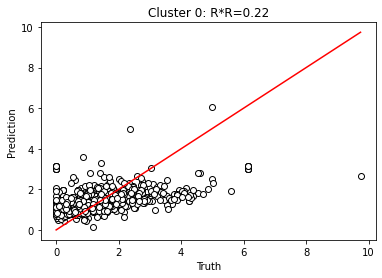

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



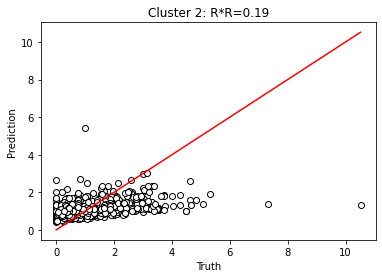

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



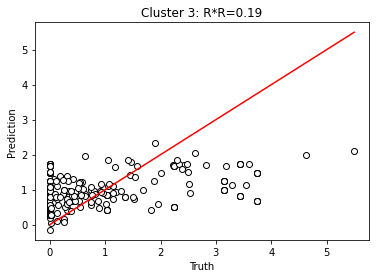

In [151]:
cluster_subset_lr_list = []
cluster_subset_lr_dict = {}

for i in range(n_cluster):
    cluster_no = i
    cluster_subset_df = clusters_df[clusters_df['class']==str(cluster_no)]
    cluster_subset_df.drop('class', axis=1, inplace=True)

    if cluster_subset_df.shape[0]>2:

        subset_y = cluster_subset_df['crimes']
        subset_X = cluster_subset_df.drop('crimes', axis=1)

        regr = ElasticNetCV(cv=5, random_state=0)
        regr.fit(subset_X, subset_y)
        y_pred = regr.predict(subset_X)
#         print("Coefficient of determination (Rsqured): %.2f" % r2_score(subset_y, y_pred))

        # regr = LassoCV(cv=5, random_state=0)
        # regr.fit(subset_X, subset_y)
        # y_pred = regr.predict(subset_X)
        # print("Coefficient of determination (Rsqured): %.2f" % r2_score(subset_y, y_pred))

        # regr = LinearRegression()
        # regr.fit(subset_X, subset_y)
        # y_pred = regr.predict(subset_X)
        # print("Coefficient of determination (Rsqured): %.2f" % r2_score(subset_y, y_pred))

        # regr = TweedieRegressor(power=0, alpha=0.5, link='log')

        # # The alpha hyperparameter
        # print("Alpha hyperparameter: ", regr.alpha_)

        # The coefficients
        # print("Coefficients: \n", regr.coef_)
#         print("Intercept: \n", regr.intercept_)
#         print("Mean squared error: %.2f" % mean_squared_error(subset_y, y_pred))
#         print("Coefficient of determination (Rsqured): %.2f" % r2_score(subset_y, y_pred))

        # Plot outputs
        plt.scatter(subset_y, y_pred, edgecolors="black", marker='o', color='white')
        plt.plot([min(subset_y), max(subset_y)], [min(subset_y), max(subset_y)], color='red')

        plt.title(f"Cluster {cluster_no}: R*R=%.2f" % r2_score(subset_y, y_pred))
        plt.xlabel("Truth")
        plt.ylabel("Prediction")
        # plt.xscale("log")
        # plt.yscale("log")
        # plt.xlim(min(subset_y), max(subset_y)/6)
        # plt.ylim(min(subset_y), max(subset_y)/6)

        plt.show()

        coef_dict = {}
        for j in range(len(regr.coef_)):
            coef_dict.update({subset_X.columns[j]:regr.coef_[j]})

        coef_dict
        
        cluster_subset_lr_dict = {
            'Cluster': i,
            'R_sq': r2_score(subset_y, y_pred),
            'coef': coef_dict
        }
        
        cluster_subset_lr_list.append(cluster_subset_lr_dict)

In [152]:
cluster_subset_lr_list

[{'Cluster': 0,
  'R_sq': 0.21956523121654192,
  'coef': {'total_law_emp': 0.18508798374296695,
   'officers': 0.45852546319990917,
   'civilians': 0.0,
   'percent_edu_less_than_high_school': -0.0,
   'percent_edu_high_school': 0.10376764040450431,
   'percent_edu_some_college': 0.14902123236323225,
   'percent_edu_bachelor_or_higher': -0.22624534391731366,
   'unemployment_rate': -0.049434227688888055,
   'median_HH_Income': 0.0,
   'population': 0.21171770210001462,
   'pop_dens_ppl_per_sqkm': 0.4792858967015584,
   'percent_poverty_all_age': -0.2799762228300414,
   'percent_poverty_age_0-17': 0.30320729813437913,
   'percent_poverty_age_5-17': -0.061082937708282534}},
 {'Cluster': 2,
  'R_sq': 0.18953780063023895,
  'coef': {'total_law_emp': 0.26817947170746487,
   'officers': 0.2274250834944189,
   'civilians': 0.005779939597879929,
   'percent_edu_less_than_high_school': 0.08414477888812397,
   'percent_edu_high_school': -0.036438112235566436,
   'percent_edu_some_college': 0.023

### Examine the distribution of "Crimes" data

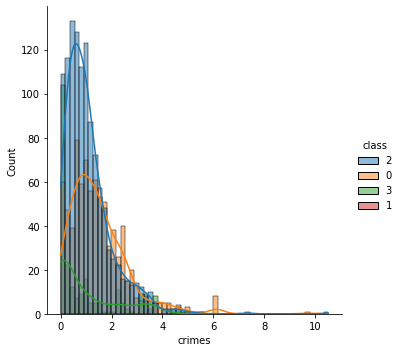

In [153]:
sns.displot(clusters_df.reset_index(), 
            x="crimes",
#             kind='kde',
#             cut=0,
            hue='class',
#             log_scale=True,
            kde=True
            )

### Try NN model

In [156]:
cluster_no = 0

In [157]:
cluster_subset_df = clusters_df[clusters_df['class']==str(cluster_no)]
cluster_subset_df.drop('class', axis=1, inplace=True)


nn_y = cluster_subset_df['crimes']
nn_X = cluster_subset_df.drop('crimes', axis=1)

X_train, X_test, y_train, y_test = train_test_split(nn_X, nn_y, random_state=78)

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_201 (Dense)           (None, 4)                 60        
                                                                 
 dense_202 (Dense)           (None, 2)                 10        
                                                                 
 dense_203 (Dense)           (None, 1)                 3         
                                                                 
 dense_204 (Dense)           (None, 1)                 2         
                                                                 
 dense_205 (Dense)           (None, 1)                 2         
                                                                 
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
None
0.2387892673181512


Text(0, 0.5, 'Predicted')

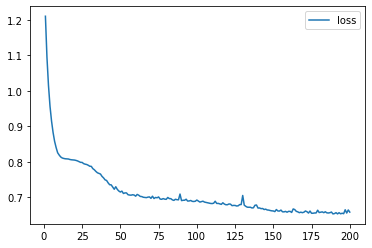

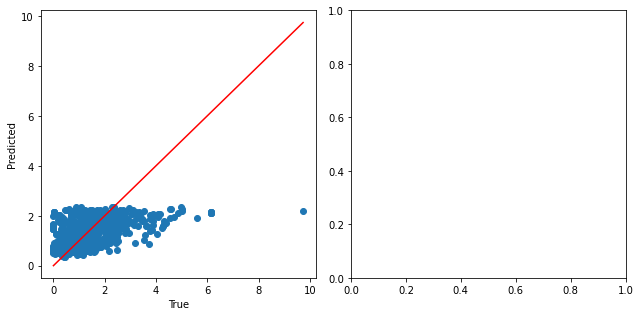

In [159]:
units_input = 4
units_h1 = 2
units_h2 = 1
units_h3 = 1
activation_input = 'tanh'
activation_h1 = 'tanh'
activation_h2 = 'tanh'
activation_h3 = 'LeakyReLU'
activation_output = 'LeakyReLU'
epochs = 200


# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=units_input, activation=activation_input, input_dim=nn_X.shape[1]))
if units_h1 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h1, activation=activation_h1))
if units_h2 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h2, activation=activation_h2))
if units_h3 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h3, activation=activation_h3))
nn_model.add(tf.keras.layers.Dense(units=1, activation=activation_output))

# Check the structure of the Sequential model
print(nn_model.summary())

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="mean_absolute_error", 
                 optimizer=tf.optimizers.Adam(learning_rate=0.001), 
#                  metrics=["r_square"]
                )

# Fit the model to the training data
fit_model = nn_model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

# compare results
result = pd.DataFrame()
result['True'] = nn_y
result['Predicted'] = nn_model.predict(nn_X)

print(r2_score(result['True'],result['Predicted']))

# compare Predicted with True
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)
ax1.scatter(result['True'],result['Predicted'])
ax1.plot([min(result['True']), max(result['True'])], [min(result['True']), max(result['True'])], 'r')
ax1.set_xlabel('True')
ax1.set_ylabel('Predicted')
# ax2.scatter(result['True'], result['Predicted'])
# ax2.plot([0, 0.2], [0, 0.2], 'r')
# ax2.set_xlim(0, 0.25)
# ax2.set_ylim(0, 0.25)
# ax2.set_xlabel('True')
# ax2.set_title('Zoom into Diagnol')

In [160]:
r2_score(result['True'],result['Predicted'])

0.2387892673181512